# 基盤DS演習 第6回

※本演習資料の二次配布・再配布はお断り致します。

　今回の演習の内容は以下の通りである。

- **DS6.0 | 次元削減とは**
- **DS6.1 | 主成分分析 (PCA) の復習**
- **DS6.2 | 多次元尺度構成法 (multidimensional scaling; MDS)**
- **DS6.3 | 正準相関分析 (Canonical Correlation Analysis; CCA)**
- **DS6.4 | 次元削減と分類予測手法の組み合わせ** 

## DS6.0 | 次元削減とは

　次元削減とは高次元のデータを低次元に射影する手法のことで、

*   **データの圧縮**による計算コストの削減
*   **ノイズの削減**による予測精度の向上
*   **データの可視化**によるデータの解析・解釈

などに用いられる。



## DS6.1 | 主成分分析 (principal component analysis; PCA)の復習

　主成分分析 (PCA) とは、長さ$K$のベクトルであるようなデータ $x_n$ を、より低次元である $r$ 次元のベクトルに線形変換するものであった。

　PCAは、観測されたデータの広がりを最もよく表すような低次元表現を与えるという意味で次元削減の手法でもある。
では、基盤データサイエンス演習 第4回でも使用したdigitsデータ（のうち300件）を用いて主成分分析を行ってみよう。

In [1]:
from sklearn import datasets
import matplotlib.pyplot as plt

num_data = 300
d = datasets.load_digits()
X = d.data[:num_data]
y = d.target[:num_data]

In [2]:
def plot_digits(X, y, n_labels=10, title=None):
  # plot X/y in 2-dimensions
  plt.figure(figsize=(5,5))

  # set color palette for plot
  color = [plt.cm.nipy_spectral(i/n_labels, 1) for i in range(n_labels)] 

  # plot by each label
  for i in range(n_labels):
    plt.scatter(X[y==i, 0], X[y==i, 1], 
                color=color[i], marker=f"${i}$")
  plt.xlabel("1st axis")
  plt.ylabel("2nd axis")
  plt.title(title)
  plt.show()

　では、実際にPCAを行い、結果を可視化してみよう。 今回は2次元に可視化するため、`n_components=2`を指定する。


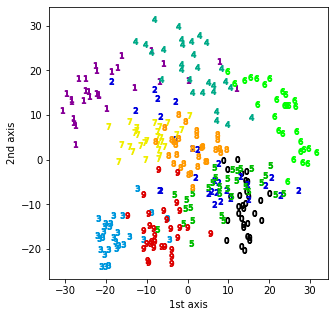

In [3]:
# prepare PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=2) # 2 components will be used
pca.fit(X) # obtain principal component
images_map = pca.transform(X) # transform input data using PCA

plot_digits(images_map, y, n_labels=10)

　PCAでは、各主成分（固有ベクトル）の値を見ることで、どの説明変数が主要な寄与をしているか、また各主成分の固有値がデータの分散のどれだけの割合を表しているか確認することができる。実際に各成分の寄与を見てみよう。

In [4]:
import pandas as pd
pca = PCA(n_components=3).fit(X) # PCA, use 3 components

columns = range(64)
indexes = ["PC1", "PC2", "PC3"]
components = pca.components_ # get components from PCA result

print(pd.DataFrame(components, index=indexes, columns=columns))

               0         1         2         3         4         5         6   \
PC1  2.913330e-18  0.000984  0.008866  0.118866 -0.056783 -0.171844 -0.044215   
PC2 -6.354556e-18 -0.023672 -0.255373 -0.246952  0.055550  0.019737  0.002306   
PC3 -4.294286e-18  0.038710  0.215437  0.123799  0.091058  0.153439  0.056270   

           7             8         9   ...        54        55   56        57  \
PC1 -0.004093  6.938894e-18  0.035431  ...  0.114250  0.002496  0.0  0.001445   
PC2  0.000985 -5.551115e-17 -0.077375  ... -0.060070  0.000430  0.0 -0.021826   
PC3  0.007944 -1.665335e-16  0.079130  ... -0.161661 -0.003160 -0.0  0.040464   

           58        59        60        61        62        63  
PC1  0.001661  0.113164  0.074104  0.013298  0.049194  0.000278  
PC2 -0.264832 -0.259050  0.005141  0.026306  0.006144 -0.001254  
PC3  0.235633  0.122043 -0.240898 -0.234537 -0.034888 -0.000164  

[3 rows x 64 columns]


---
##### 課題 DS6.1

　下の文章について、二つの空欄[  A  ], [  B  ]にそれぞれ適切な語句を埋めて文章を完成させよ。

![swiss_role](https://i.imgur.com/YDGNKRS.png)

```
PCAではデータの分散が最大となる方向が軸となるように低次元化する手法であった。
一方、データの特徴を表す向きが直線でない場合もある。図はswiss-roleデータセットと呼ばれ、平面のデータを曲げて三次元にしたデータである。
適切に低次元化した場合、巻く方向とそれに直交する方向の2軸（2次元の情報）でこのデータを表すことができる。

一方、PCAでは、このように各変数に[  A  ]な関係がないが、[  B  ]な関係があるデータに対しては適切に低次元化ができない。
```

--------

##### 課題 DS6.2（発展）
　課題 DS6.1で示したような swiss-role データセットについて、うずまきの内側とうずまきの外側を分離することのできる次元削減手法を調べて答えよ。

---
## DS6.2 | 多次元尺度構成法 (multidimensional scaling; MDS)

　PCAはデータ全体の広がりを保つように低次元化する手法であったが、MDSは**データの組の距離関係をできるだけ再現するように低次元化する手法**である。MDSにはMetric MDSとNonmetric MDSがあり、いずれも元の空間での各データ点間の非類似度（dissimilarity, 距離のようなもの）が与えられている必要がある。ここでは、Metric MDSに絞って実行してみよう。

　Metric MDSではデータ点間の非類似度が変換前後で一致するような低次元化を行う。数学的に表現すると、射影前の空間での非類似度$d_{ij}$と射影後の非類似度$\|z_i - z_j\|$の差を最小化する、つまり
$$
\min_{z_1, \ldots, z_n \in \mathbb{R}^r} \sum_{i, j}\left(d_{ij} - \|z_i - z_j\|\right)^2
$$
を解く。なお、scikit-learnのMetric MDSは、デフォルトではデータ間のユークリッド距離（画像であれば、1つの画像の各画素の値をN次元ベクトルとみて、N次元空間における画像間のユークリッド距離）を非類似度として用いる。



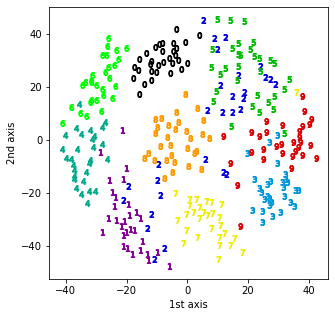

In [5]:
from sklearn.manifold import MDS
mds = MDS(n_components=2, metric=True, random_state=0) # metric MDS
X_low = mds.fit_transform(X)

plot_digits(X_low, y, n_labels=10)

　なお、MDSは内部にランダムな要素を含むアルゴリズムであり、乱数のシード `random_state` によって結果が変化する。乱数のシードを変更し、結果が変わることを確かめてほしい。

## DS6.3 | 正準相関分析 (Canonical Correlation Analysis; CCA)

　CCAは**組になっている**二変数の列$$(x_1, z_1), \ldots, (x_n, z_n)$$に対して、**$x$と$z$に共通した**低次元表現を与える手法である。これを求めるために、
$$
\min_{A,B}\frac{1}{n} \sum_{i=1}^{n}\|A^T x_i - B^T z_i \|^2 \ \ \ \
{\rm s.t. }\ \ 
\mathbb{V}[A^T x_i]=\mathbb{V}[B^T z_i] = I_r
$$
を解いて変換$A$, $B$を求める。

　CCAでは例えば、$x$, $z$がそれぞれ1次元のデータで、$c_i$はシグナル、$n_i, n'_i$はノイズ、$\varepsilon$は小さい定数とし、
$$ \left\{
\begin{array}{l} 
x_i= \varepsilon c_i+n_i \\
z_i= \varepsilon c_i+n'_i \\
\end{array}
\right.$$
であるようなとき、PCAではノイズ$n_i, n_i'$を強く検出してしまうが、CCAは$c_i$を検出することが可能である。なお、次の例で取り扱うように、CCAでは$x$と$z$の次元数は等しくなくてもよい。

### DS6.3.1 | CCAの実行

　今回は、講義で行ったようにdigitsデータの画像の上部と下部のデータにCCAを適用し、それらが関連付けられる様子を見てみよう。ここでは画像の最初の48次元が$x$、後の16次元が$z$である。

![digits split](https://i.imgur.com/xP3OAuI.png)

In [6]:
num_data = 300
d = datasets.load_digits()
D = d.data[:num_data]
y = d.target[:num_data]

X = D[:, :48] # 0...47  feature
Z = D[:, 48:] # 48...63 feature

In [7]:
# projection by CCA
from sklearn.cross_decomposition import CCA
cca = CCA(n_components=2, scale=True)
cca.fit(X, Z)
Xc, Zc = cca.transform(X, Z)

D:\Softwares\Anaconda\envs\tf\lib\site-packages\sklearn\cross_decomposition\_pls.py:77: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)


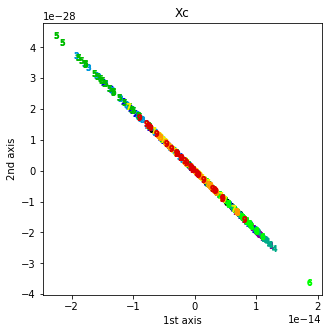

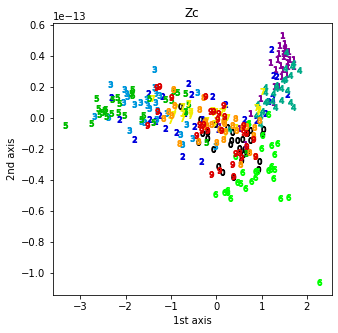

In [8]:
# plot results
plot_digits(Xc, y, title="Xc")
plot_digits(Zc, y, title="Zc")

　実行結果から、$X$と$Z$が似た形状の空間に射影されており、また同じ数字は同じような位置に射影されている。

この結果から、CCAによって画像の上部分と下部分が関連付けられた低次元表現が得られたことがわかる。

---
##### 課題 DS6.3
　CCAによって得られた低次元表現で$X$と$Z$が関連付けられていることを定量的に確認しよう。
CCAを用いて$X$と$Z$を**1次元**に射影したとき、$X$から求められた値と$Z$から求められた値との相関係数 (correlation coefficient) はいくらになるか。小数点以下2桁で答えよ。

---
### DS6.3.2 | CCAによる画像の復元（発展）

　基盤データサイエンス演習 第4回 では、PCAで得られた複数の主成分から画像を再構成することを行った。ここでは、似たような取り組みとして、CCAを用いて低次元化した画像を復元してみよう。


In [9]:
# prepare dataset
num_data = 300
d = datasets.load_digits()
D = d.data[:num_data]
y = d.target[:num_data]

X = D[:, :48] # 0...47  feature
Z = D[:, 48:] # 48...63 feature

# prepare one test image
image_index = 0
X_test = D[image_index, :48].reshape(1, -1)
Z_test = D[image_index, 48:].reshape(1, -1)


In [10]:
# projection and inverse-projection by CCA
from sklearn.cross_decomposition import CCA
cca = CCA(n_components=16, scale=True)
cca.fit(X, Z)
Xc, Zc = cca.transform(X, Z)

X_test_map, Z_test_map = cca.transform(X_test, Z_test)
X_recovered_from_X = cca.inverse_transform(X_test_map)
X_recovered_from_Z = cca.inverse_transform(Z_test_map)

D:\Softwares\Anaconda\envs\tf\lib\site-packages\sklearn\cross_decomposition\_pls.py:77: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)


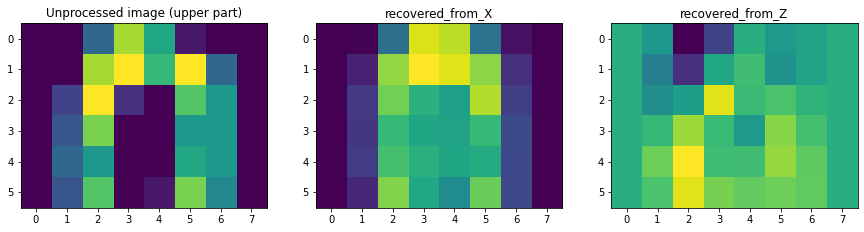

In [11]:
# plot 3 images
X_test_image = X_test.reshape(6, 8)
X_recovered_from_X_image = X_recovered_from_X.reshape(6, 8)
X_recovered_from_Z_image = X_recovered_from_Z.reshape(6, 8)

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(X_test_image)
plt.title("Unprocessed image (upper part)")

plt.subplot(1, 3, 2)
plt.imshow(X_recovered_from_X_image)
plt.title("recovered_from_X")

plt.subplot(1, 3, 3)
plt.imshow(X_recovered_from_Z_image)
plt.title("recovered_from_Z")

plt.show()

上の3セルを実行すると三つの画像が出てくる。

左から、それぞれ元の画像の上側、上側を変換・逆変換して上側を復元したもの、下側を変換・逆変換して上側を復元したものである。

`image_index`や`n_components`を変更していくつかの例を試してみよう。
CCAによって画像の上側と下側を関連付けることにより、画像の下側から上側をある程度の精度で復元することが可能になった。


## DS6.4 | 次元削減と分類予測手法の組み合わせ

　次元削減の利用法の一つとして、高次元のデータを一旦次元削減し、それから別の機械学習手法を適用するというものがある。次元削減手法により、データをうまく表現する特徴量を抽出し、小さなデータセットでも汎用的なモデルを作成するのである。

　ここでは、digitsデータセットのうち**500件のみを訓練データ**として、PCAを用いて低次元化を行って学習した場合に、予測精度がどのように変化するか確認する。



In [12]:
from sklearn import datasets
d = datasets.load_digits()
X = d.data
y = d.target

In [13]:
from sklearn.model_selection import train_test_split

# これまでと異なり、train_test_split() を使ってデータを分割しておく
# 引数 train_size に実数値ではなく整数値を与えると、
# その数のデータだけを訓練データに、残りはテストデータにする
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=500, random_state=0) 

print(X_train, y_train)

[[ 0.  0.  5. ...  8.  1.  0.]
 [ 0.  0.  9. ...  7.  0.  0.]
 [ 0.  0.  0. ... 16.  4.  0.]
 ...
 [ 0.  0.  5. ...  0.  0.  0.]
 [ 0.  0.  4. ...  0.  0.  0.]
 [ 0.  0.  6. ... 11.  0.  0.]] [0 9 6 9 8 4 5 8 1 6 3 0 4 6 1 8 3 4 7 1 0 7 9 2 7 2 1 6 9 3 1 3 2 4 3 4 3
 3 5 4 7 3 6 7 0 0 1 1 0 2 0 7 7 4 7 2 0 1 2 4 8 1 6 0 3 4 0 6 8 4 4 9 0 8
 4 6 8 7 8 2 8 1 6 6 9 5 3 8 5 1 3 3 1 8 8 3 0 4 1 7 2 7 4 0 4 2 7 7 9 1 9
 0 9 3 8 6 2 5 3 3 7 2 1 0 8 7 7 3 1 2 4 5 7 7 9 1 5 5 2 8 7 9 4 7 0 2 6 1
 3 1 3 7 3 6 7 1 6 6 1 0 6 9 7 7 4 4 9 1 5 1 1 7 2 6 6 4 3 1 0 5 3 9 5 8 1
 7 9 9 8 2 1 0 6 6 4 4 7 8 6 5 8 8 2 2 2 9 8 8 3 6 0 4 4 7 6 6 9 0 4 6 8 5
 1 9 9 3 1 6 5 9 7 3 4 4 2 4 4 9 2 9 9 7 2 3 3 3 7 2 7 8 1 0 5 6 6 8 0 7 0
 4 2 6 6 8 6 4 7 7 0 3 0 7 4 0 0 2 1 8 4 2 2 9 9 3 3 4 4 2 6 3 7 2 8 4 2 9
 5 1 9 0 9 7 2 6 2 1 6 9 9 3 8 3 6 2 2 4 9 3 4 6 8 6 1 7 4 1 4 7 0 1 5 6 2
 7 8 4 9 0 9 0 5 2 2 4 1 8 8 7 2 9 7 0 0 6 0 5 0 5 1 0 8 6 6 0 3 4 0 3 5 6
 9 8 4 8 5 2 7 5 5 1 1 8 9 0 3 4 9 2 9 3 1 7 5 4 9 5 7 7 7

　それでは、まず `X_train` だけを使ってPCAの構築を行う。その後の機械学習のためのPCAの場合には、 `n_components` の値は可視化に比べると大き目の値に設定することが多い。

In [14]:
from sklearn.decomposition import PCA

pca = PCA(n_components=10)
pca.fit(X_train) 

PCA(n_components=10)

　続いて、 `X_train`、`X_test` それぞれをPCAで次元削減する。

In [15]:
new_X_train = pca.transform(X_train)
new_X_test  = pca.transform(X_test)

　ここまでくれば、後は通常の機械学習と同様である。ここでは深さなどを特に制限しない決定木を用いることにしてみよう。

In [16]:
from sklearn.tree import DecisionTreeClassifier

# training
dt = DecisionTreeClassifier(random_state=0)
dt.fit(new_X_train, y_train)

# prediction 
y_pred = dt.predict(new_X_test)

# evaluation
accuracy = (y_pred == y_test).mean()
print(accuracy)

0.7987663839629915


　なお、この PCA -> 決定木 という流れも、基盤AI演習で学んだ `make_pipeline()` を使うことができる。同一の正解率が得られることを確認せよ。

In [17]:
from sklearn.pipeline import make_pipeline

# training
pca_dt = make_pipeline(
  PCA(n_components=10), 
  DecisionTreeClassifier(random_state=0)
)

pca_dt.fit(X_train, y_train)

# prediction 
y_pred = pca_dt.predict(X_test)

# evaluation
accuracy = (y_pred == y_test).mean()
print(accuracy)

0.7987663839629915


　最後に、次元削減を行わなかった場合のテストデータの正解率と比較してみよう。

In [18]:
# training
dt = DecisionTreeClassifier(random_state=0)
dt.fit(X_train, y_train)

# prediction
y_pred = dt.predict(X_test)

# evaluation
accuracy = (y_pred == y_test).mean()
print(accuracy)

0.7717810331534309


　わずかではあるが、次元削減によってテストデータに対する正解率が向上したことが確認できた。

------

##### 課題 DS6.4
　`n_components` の数を1から10まで変動させ、次元削減を行わなかった場合に比べてテストデータの予測精度が向上する `n_components` を列挙せよ（決定木には上記のコードと同様に `random_state=0` を指定すること）。


---
##### 課題 DS6.5
　課題 DS6.4の結果について、なぜこのような結果になったと考えられるか、「PCAの累積寄与率」「過学習」「バイアスとバリアンス」「モデルの複雑さ」などの単語を適宜利用して考察せよ。必要に応じて、決定木の深さを制限するなどして追加の実験を行っても良い。

---
# レポート提出について



## レポートの提出方法

　レポートは**答案テンプレートを用い**、**1つのファイル（.doc, .docx, .pdf）**にまとめ、**学籍番号と氏名を確認の上**、**次回 基盤データサイエンス演習 の開始時刻までに東工大ポータルのOCW-iから提出**すること。
ファイルのアップロード後、OCW-iで「提出済」というアイコンが表示されていることを必ず確認すること。それ以外の場合は未提出扱いとなるので十分注意すること。
また、締め切りを過ぎるとファイルの提出ができないため、時間に余裕を持って提出を行うこと。

## 答案テンプレート

```
学籍番号:
名前:

課題 DS6.1
[ A ]: 
[ B ]:  

課題 DS6.2
（解答を記述せよ）

課題 DS6.3
相関係数：

課題 DS6.4
（解答を記述せよ）

課題 DS6.5
（解答を記述せよ）
```